# Model - Convolutional Neural Network

In the case of the CNN classifier, we applied word-embedding procedures
from the pre-processed texts using the word2vec API of Python Package, Gensim. The word vectors were pretrained
with the training dataset collected for the current study with continuous bag-of-words representation
(CBOW) models.

##### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For handling imbalanced classes
from collections import Counter
from imblearn.over_sampling import SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.layers import Flatten, Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalMaxPooling1D

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

##### Load data

In [2]:
posts = pd.read_csv('../data/posts-preprocessed.csv')

In [3]:
posts.head(1)

,author,created_utc,subreddit,timeframe,text_clean,sent_tokens,word_tokens
0,sub30605,1499390694,bulimia,pre-covid,chest anyone else experience chest purging kno...,['chest anyone else experience chest purging k...,"['chest', 'anyone', 'else', 'experience', 'che..."


##### Binarize targets using get_dummies

Will use each subreddit as target

In [4]:
posts = pd.get_dummies(posts, columns=['subreddit'])

### Tokenizing the raw text

We will vectorize the text and prepare a training and validation split

In [5]:
texts = posts['text_clean']

In [6]:
maxlen = 1000 # Cuts off posts after 1000 words
max_words = 5000 # Considers the top specified number of words in the dataset

In [7]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)

In [8]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [9]:
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=maxlen)

### Parcing the word2vec embeddings File

We will use our previously created word2vec embeddings

#### Parsing the word-embeddings files

In [10]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [11]:
embedding_dim = 50 

embedding_matrix = create_embedding_matrix('../embedding_word2vec.txt',
                                           tokenizer.word_index, embedding_dim)

In [12]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7723224480474994

This means about 77% of the vocabulary is covered by the pre-trained model... that doesn't seem great.. maybe we can achieve better coverage by tweaking our word2vec model in the previous notebook. 

In [13]:
X = data

# Subreddit: Anxiety

In [14]:
labels = posts['subreddit_Anxiety']

In [15]:
labels = np.asarray(labels)
print('Shape of data:', data.shape)
print('Shape of label:', labels.shape)

Shape of data: (84879, 1000)
Shape of label: (84879,)


#### Train test split

In [16]:
y = labels

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = .2,
                                                    random_state=42)

SMOTE for class imbalance

In [18]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with the imbalanced classes

In [19]:
counter = Counter(y_train)
print(counter)

Counter({0: 60349, 1: 7554})


Above we see the extent to which our classes are imbalanced, our "non-anxiety" class has 50,349 observations and our "anxiety" class has 7544 observations.

Help from: https://realpython.com/python-keras-text-classification/

In [20]:
model1 = Sequential()
model1.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model1.add(layers.Conv1D(128, 5, activation='relu'))
model1.add(Dropout(0.25))
model1.add(layers.GlobalMaxPooling1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          1094750   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          32128     
_________________________________________________________________
dropout (Dropout)            (None, 996, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,128,179
Trainable params: 1,128,179
Non-trainable params: 0
______________________________________________

In [21]:
history = model1.fit(X_train, y_train,
                    epochs= 4, # Change this number for early stopping based on results
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/4
6791/6791 [==============================] - 204s 30ms/step - loss: 0.2898 - accuracy: 0.8960 - val_loss: 0.2650 - val_accuracy: 0.9006
Epoch 2/4
6791/6791 [==============================] - 192s 28ms/step - loss: 0.2240 - accuracy: 0.9149 - val_loss: 0.2529 - val_accuracy: 0.9065
Epoch 3/4
6791/6791 [==============================] - 189s 28ms/step - loss: 0.1907 - accuracy: 0.9273 - val_loss: 0.2575 - val_accuracy: 0.9078
Epoch 4/4
6791/6791 [==============================] - 193s 28ms/step - loss: 0.1502 - accuracy: 0.9464 - val_loss: 0.2869 - val_accuracy: 0.8863


### Define function to plot the accuracy scores

In [22]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Plot accuracy scores and loss values

In [23]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9700
Testing Accuracy:  0.8863


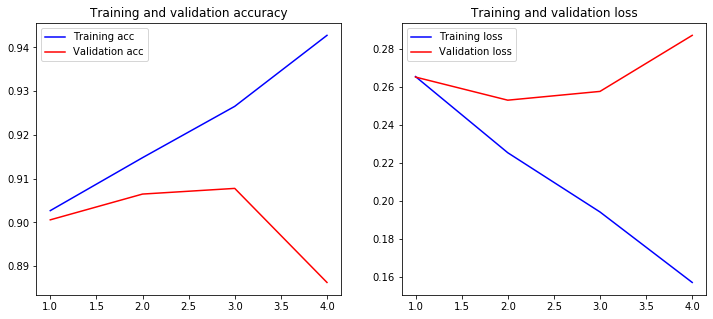

In [24]:
plot_history(history)
plt.savefig('../images/anxiety_cnn_imbal.png');

#### Defining a model using SMOTE to balance the classes

In [25]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60349, 1: 60349})


As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

In [26]:
model1_sm = Sequential()
model1_sm.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model1_sm.add(layers.Conv1D(128, 5, activation='relu'))
model1_sm.add(layers.GlobalMaxPooling1D())
model1_sm.add(layers.Dense(10, activation='relu'))
model1_sm.add(layers.Dense(1, activation='sigmoid'))
model1_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1_sm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,128,179
Trainable params: 1,128,179
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model1_sm.fit(X_train_sm, y_train_sm,
                    epochs= 5, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64) # number of samples before updating the internal model parameters

Epoch 1/5
1886/1886 [==============================] - 181s 95ms/step - loss: 0.4746 - accuracy: 0.7607 - val_loss: 0.3642 - val_accuracy: 0.8604
Epoch 2/5
1886/1886 [==============================] - 180s 96ms/step - loss: 0.2511 - accuracy: 0.8975 - val_loss: 0.3851 - val_accuracy: 0.8387
Epoch 3/5
1886/1886 [==============================] - 183s 97ms/step - loss: 0.1778 - accuracy: 0.9325 - val_loss: 0.4317 - val_accuracy: 0.8304
Epoch 4/5
1886/1886 [==============================] - 195s 103ms/step - loss: 0.1258 - accuracy: 0.9529 - val_loss: 0.5629 - val_accuracy: 0.8154
Epoch 5/5
1886/1886 [==============================] - 191s 101ms/step - loss: 0.0887 - accuracy: 0.9681 - val_loss: 0.6041 - val_accuracy: 0.8276


In [28]:
loss, accuracy = model1_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9814
Testing Accuracy:  0.8276


### Plot accuracy scores and loss values

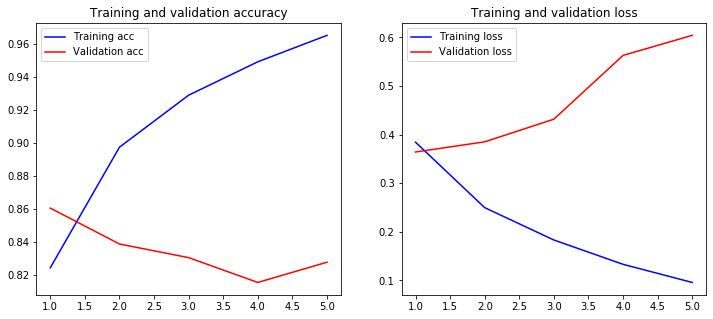

In [29]:
plot_history(history)
plt.savefig('../images/anxiety_cnn_smote.png');

# Subreddit: Anorexia Nervosa

In [30]:
labels = posts['subreddit_AnorexiaNervosa']

#### Train test split

In [31]:
X = data
y = labels

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = .2,
                                                    random_state=42)

SMOTE for class imbalance

In [33]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with the imbalanced classes

In [34]:
counter = Counter(y_train)
print(counter)

Counter({0: 60170, 1: 7733})


Above we see the extent to which our classes are imbalanced, our "non-anorexia nervosa" class has 60,170 observations and our "anorexia nervosa" class has 7733 observations.

In [35]:
model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(128, 5, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,128,179
Trainable params: 1,128,179
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
6791/6791 [==============================] - 167s 25ms/step - loss: 0.2346 - accuracy: 0.9103 - val_loss: 0.1720 - val_accuracy: 0.9374
Epoch 2/3
6791/6791 [==============================] - 167s 25ms/step - loss: 0.1495 - accuracy: 0.9434 - val_loss: 0.1701 - val_accuracy: 0.9381
Epoch 3/3
6791/6791 [==============================] - 166s 24ms/step - loss: 0.1129 - accuracy: 0.9588 - val_loss: 0.1877 - val_accuracy: 0.9352
Training Accuracy: 0.9735
Testing Accuracy:  0.9352


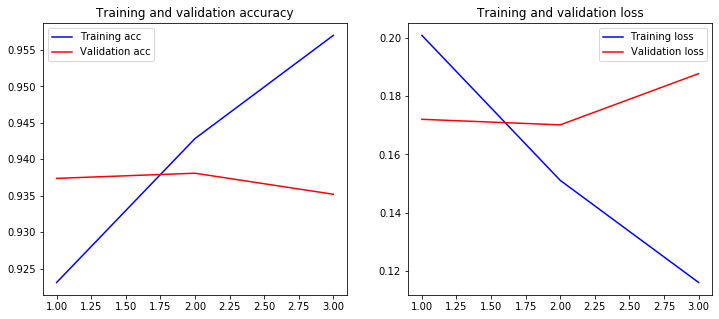

In [36]:
history = model2.fit(X_train, y_train,
                    epochs=3, # Change this number for early stopping
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

#### Defining a model using SMOTE to balance the classes

In [38]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60170, 1: 60170})


As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

#### Defining a model

In [39]:
model2_sm = Sequential()
model2_sm.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2_sm.add(layers.Conv1D(128, 5, activation='relu'))
model2_sm.add(layers.GlobalMaxPooling1D())
model2_sm.add(layers.Dense(10, activation='relu'))
model2_sm.add(layers.Dense(1, activation='sigmoid'))
model2_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2_sm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 1,128,179
Trainable params: 1,128,179
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model2_sm.fit(X_train_sm, y_train_sm,
                    epochs= 5, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Epoch 1/5
1881/1881 [==============================] - 178s 94ms/step - loss: 0.4616 - accuracy: 0.7586 - val_loss: 0.3257 - val_accuracy: 0.8603
Epoch 2/5
1881/1881 [==============================] - 172s 91ms/step - loss: 0.2237 - accuracy: 0.9061 - val_loss: 0.3195 - val_accuracy: 0.8657
Epoch 3/5
1881/1881 [==============================] - 171s 91ms/step - loss: 0.1528 - accuracy: 0.9390 - val_loss: 0.3378 - val_accuracy: 0.8599
Epoch 4/5
1881/1881 [==============================] - 171s 91ms/step - loss: 0.1023 - accuracy: 0.9613 - val_loss: 0.3959 - val_accuracy: 0.8640
Epoch 5/5
1881/1881 [==============================] - 171s 91ms/step - loss: 0.0686 - accuracy: 0.9739 - val_loss: 0.5496 - val_accuracy: 0.8309


In [41]:
loss, accuracy = model2_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9815
Testing Accuracy:  0.8309


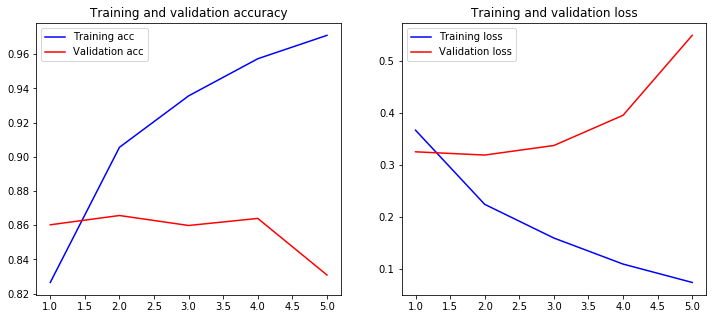

In [42]:
plot_history(history)
plt.savefig('../images/anorexia_cnn_smote.png');

# Subreddit: Schizophrenia

In [43]:
labels = posts['subreddit_schizophrenia']

#### Train test split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size = .2,
                                                    random_state=42)

In [45]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with imbalanced classes

In [46]:
counter = Counter(y_train)
print(counter)

Counter({0: 60303, 1: 7600})


In [47]:
model4 = Sequential()
model4.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model4.add(layers.Conv1D(128, 5, activation='relu'))
model4.add(layers.GlobalMaxPooling1D())
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,128,179
Trainable params: 1,128,179
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model4.fit(X_train, y_train,
                    epochs= 5, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=65)

Epoch 1/5
1045/1045 [==============================] - 100s 96ms/step - loss: 0.3293 - accuracy: 0.8812 - val_loss: 0.2389 - val_accuracy: 0.9118
Epoch 2/5
1045/1045 [==============================] - 98s 94ms/step - loss: 0.2209 - accuracy: 0.9137 - val_loss: 0.2399 - val_accuracy: 0.9103
Epoch 3/5
1045/1045 [==============================] - 98s 94ms/step - loss: 0.1853 - accuracy: 0.9282 - val_loss: 0.2547 - val_accuracy: 0.9043
Epoch 4/5
1045/1045 [==============================] - 98s 94ms/step - loss: 0.1339 - accuracy: 0.9497 - val_loss: 0.2882 - val_accuracy: 0.8992
Epoch 5/5
1045/1045 [==============================] - 98s 94ms/step - loss: 0.0831 - accuracy: 0.9712 - val_loss: 0.3690 - val_accuracy: 0.8827


In [49]:
loss, accuracy = model4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9843
Testing Accuracy:  0.8827


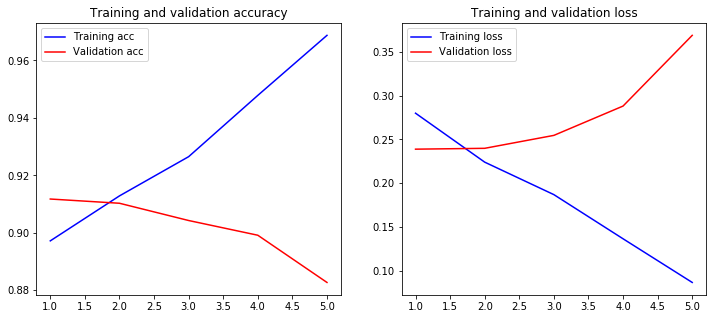

In [50]:
plot_history(history)
plt.savefig('../images/schiz_cnn_imbal.png');

#### Defining a model using SMOTE to balance the classes

In [51]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60303, 1: 60303})


As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

#### Defining a model

In [52]:
model4_sm = Sequential()
model4_sm.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model4_sm.add(layers.Conv1D(128, 5, activation='relu'))
model4_sm.add(layers.GlobalMaxPooling1D())
model4_sm.add(layers.Dense(10, activation='relu'))
model4_sm.add(layers.Dense(1, activation='sigmoid'))
model4_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model4_sm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 1,128,179
Trainable params: 1,128,179
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model4_sm.fit(X_train_sm, y_train_sm,
                    epochs=5, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Epoch 1/5
1885/1885 [==============================] - 172s 91ms/step - loss: 0.4844 - accuracy: 0.7451 - val_loss: 0.4019 - val_accuracy: 0.8096
Epoch 2/5
1885/1885 [==============================] - 168s 89ms/step - loss: 0.2676 - accuracy: 0.8930 - val_loss: 0.4654 - val_accuracy: 0.7846
Epoch 3/5
1885/1885 [==============================] - 169s 89ms/step - loss: 0.1900 - accuracy: 0.9270 - val_loss: 0.4536 - val_accuracy: 0.8152
Epoch 4/5
1885/1885 [==============================] - 168s 89ms/step - loss: 0.1281 - accuracy: 0.9524 - val_loss: 0.5907 - val_accuracy: 0.7816
Epoch 5/5
1885/1885 [==============================] - 168s 89ms/step - loss: 0.0894 - accuracy: 0.9678 - val_loss: 0.7027 - val_accuracy: 0.7941


In [54]:
loss, accuracy = model4_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9753
Testing Accuracy:  0.7941


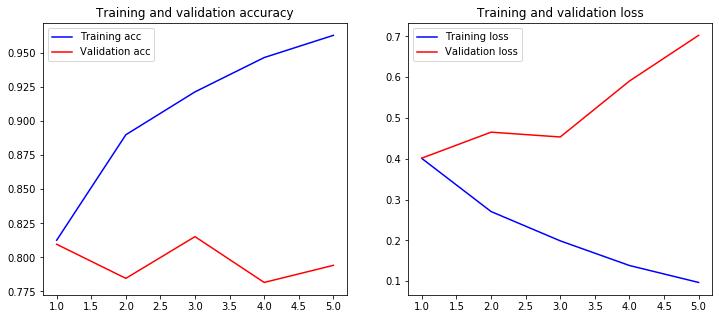

In [55]:
plot_history(history)
plt.savefig('../images/schiz_cnn_smote.png');

# CNN with all subreddits

In [56]:
labels = posts.drop(columns = ['word_tokens', 'sent_tokens', 'text_clean', 'timeframe', 'created_utc', 'author'])

In [60]:
labels.columns

Index(['subreddit_AnorexiaNervosa', 'subreddit_Anxiety', 'subreddit_BPD',
       'subreddit_autism', 'subreddit_bipolar', 'subreddit_bulimia',
       'subreddit_depression', 'subreddit_mentalhealth',
       'subreddit_schizophrenia'],
      dtype='object')

In [59]:
labels.shape

(84879, 9)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    stratify = y,
                                                    test_size = .2,
                                                    random_state=42)

In [62]:
model5 = Sequential()
model5.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model5.add(layers.Conv1D(128, 5, activation='relu'))
model5.add(layers.GlobalMaxPooling1D())
model5.add(layers.Dense(10, activation='relu'))
model5.add(layers.Dense(9, activation='softmax'))
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 99        
Total params: 1,128,267
Trainable params: 1,128,267
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model5.fit(X_train, y_train,
                    epochs=5, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Epoch 1/5
1061/1061 [==============================] - 110s 103ms/step - loss: 1.8643 - accuracy: 0.2991 - val_loss: 1.3966 - val_accuracy: 0.5145
Epoch 2/5
1061/1061 [==============================] - 115s 109ms/step - loss: 1.3172 - accuracy: 0.5442 - val_loss: 1.3480 - val_accuracy: 0.5341
Epoch 3/5
1061/1061 [==============================] - 119s 112ms/step - loss: 1.1746 - accuracy: 0.5953 - val_loss: 1.3605 - val_accuracy: 0.5389
Epoch 4/5
1061/1061 [==============================] - 124s 117ms/step - loss: 1.0611 - accuracy: 0.6338 - val_loss: 1.3974 - val_accuracy: 0.5349
Epoch 5/5
1061/1061 [==============================] - 120s 113ms/step - loss: 0.9517 - accuracy: 0.6784 - val_loss: 1.4513 - val_accuracy: 0.5243
